In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

### Import Data

In [2]:
path = 'lalonde.csv'
patients_df = pd.DataFrame.from_csv(path, sep=",")
patients_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Clean Data

In [3]:
# Cast values to numeric
patients_df.apply(pd.to_numeric, errors = 'coerce')
type(patients_df.iloc[1,1])

numpy.int64

### Split not treated and treated

In [4]:
# splits a dataframe on a two-categorical column by values
def split_in_two(df, column):
    first = df[df[column] == 0]
    second = df[df[column] == 1]
    return first, second

In [5]:
ntreated_df, treated_df = split_in_two(patients_df, 'treat')
treated_df.tail(2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW184,1,35,8,1,0,1,1,13732.07,17976.15,3786.628
NSW185,1,33,11,1,0,1,1,14660.71,25142.24,4181.942


In [6]:
ntreated_df.head(2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67


### 1. A naive analysis

Now that we have the treated and untreated person, we can compare the outcome variable

In [7]:
ntreated_df['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [8]:
treated_df['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

We can see that we already have a problem because there is much more people not treated than treated and the mean is higher for the not treated person than the treated one. We can see that it may deteriorate the final result and our conclusion

Now, we need to find the max values and the min values for the plot to have a good scale

In [51]:
def get_min_max(df, first_col, last_col):
    values = df.loc[:, first_col:last_col]
    min_value = values.min().min()
    max_value = values.max().max()
    return min_value, max_value

In [52]:
min_re, max_re = get_min_max(patients_df, 're74', 're78')
max_re

60307.93

Now we will compare the outcome variable (re74, re75 and re78) with plots

In [11]:
def get_column_serie(df, column):
    return df[[column]].values[:, 0]

In [12]:
#Have the good scale for the plot
def create_bins(min_val, max_val, interval):
    bins_ = []
    for i in range(int(min_val), int(max_val), interval):
        bins_.append(i)
    return bins_

In [13]:
cut_range = 2000
bins_ = create_bins(min_re, max_re, cut_range)

In [14]:
#to plot a histogram to visualise the data
def make_comparative_histogram(df1, df2, column, bins_param, xlabel, legends):
    serie1 = get_column_serie(df1, column)
    serie2 = get_column_serie(df2, column)
    
    plt.hist([serie1, serie2], bins=bins_param,  edgecolor="k")
    plt.xlabel(xlabel)
    plt.legend(legends)
    plt.show()

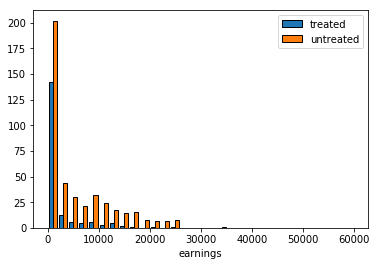

In [15]:
make_comparative_histogram(treated_df, ntreated_df, 're74', bins_, 'earnings', ['treated', 'untreated'])

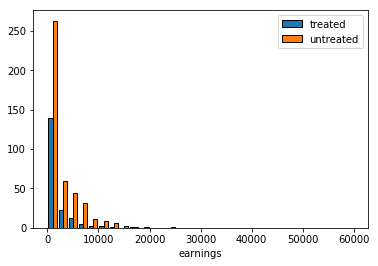

In [16]:
make_comparative_histogram(treated_df, ntreated_df, 're75', bins_, 'earnings', ['treated', 'untreated'])

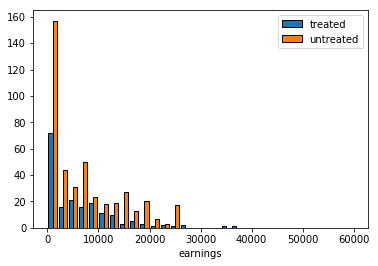

In [17]:
make_comparative_histogram(treated_df, ntreated_df, 're78', bins_, 'earnings', ['treated', 'untreated'])

Here the naive analysis might conclude that the treatment doesn't work. We can conclude this because the average income of the not treated group is always higher than the treated group.

### 2. A closer look at the data

We will now compare the real income values and this time use all the data that we can have (ages and education level). However, the race, marriage and treatment don't make much sens for the comparison but we will try to analyse it.

In [83]:
def shared_plot_by(col,plot_kind, treated_df, ntreated_df):
    fig, axs = plt.subplots(1, 2, figsize=(14,5), sharex=True)
    treated_df.plot(y=col, kind=plot_kind, ax=axs[0], title = "Treated")
    ntreated_df.plot(y=col, kind=plot_kind, ax=axs[1], title = "Not Treated")
    plt.show()

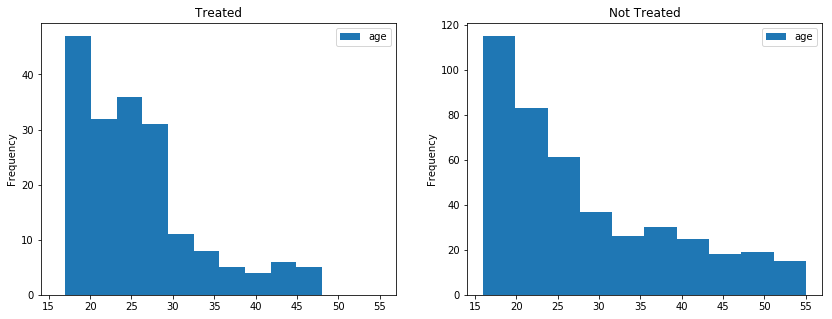

In [84]:
# First we can compare them by age
shared_plot_by('age', 'hist', treated_df, ntreated_df)

In [85]:
# And we can compare the values with descibe
treated_df['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [86]:
ntreated_df['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

We can see (with plots and numbers) that among the data, most of them are young people (16-25) and there are much more people not treated than treated. So with the naive approach we can say that the young people aren't interested about doing an other training job. However our assumption can be wrong because we only analyse the naive approach ...

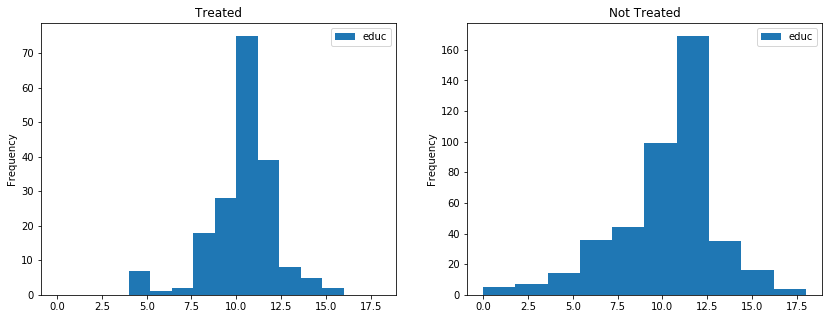

In [87]:
# Then by education
shared_plot_by('educ', 'hist', treated_df, ntreated_df)

In [88]:
# and compare their values too
treated_df['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [89]:
ntreated_df['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

The distributions of education can be compared to a gaussian distribution with both mean around 10. Furthermore, we can see again that there are much more people who have not been treated. 


With the naive approach, the distribution is wider. We can conclude that after around 10 years of studies, you would be willing to do a training job which can bring more skills for a job.

Now for the race, marriage and node degree we just have values 0 and 1 so we count them and can plot them all together to see their differencies

In [90]:
def col_number(df, col_names):
    result_0 = []
    result_1 = []
    
    for col_name in col_names:   
        # for each col we calculate the length and then store the ratio
        nb_0 = len(df[df[col_name] == 0])
        nb_1 = len(df[df[col_name] == 1])
        result_0.append(nb_0 / (nb_0 + nb_1))
        result_1.append(nb_1 / (nb_0 + nb_1))
        
    return np.array(result_0), np.array(result_1)

def bar_subplot(axe_plot, nb_index, result_0, result_1, ylegend):
    plot0 = axe_plot.bar(nb_index, result_0, color="#0000ff")
    plot1 = axe_plot.bar(nb_index, result_1, bottom = result_0, color='#ff3333')
    
    plt.sca(axe_plot)
    plt.xticks(nb_index, col_names)
    plt.ylabel(ylegend)
    plt.yticks( [0, 0.5, 1] )
    plt.legend((plot0[0], plot1[0]), ('0', '1'))

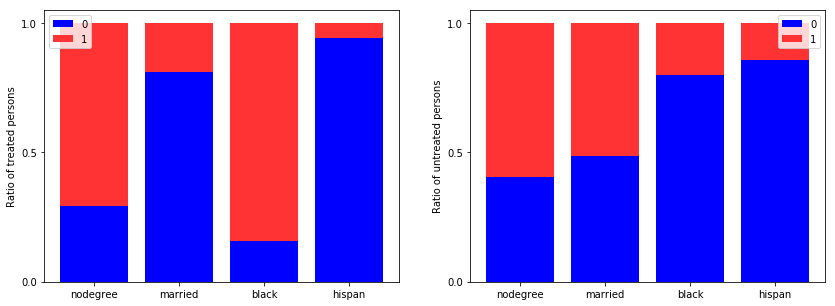

In [91]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(4)
col_names = ['nodegree', 'married', 'black', 'hispan']

result_0, result_1 = col_number(treated_df, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(ntreated_df, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons')

plt.show()

It's very difficult to say something about these values. It seems that the people without a degree took the training because they didn't have a diploma.<br>
For the married people, most of them took the job training and same applies to white people. However we know that the proportions of the treated and untreated people are not the same so our final results aren't coherent...<br>

### 3. A propsensity score model

Here we just need to train on all the data and display the probability of being treated or not treated

In [27]:
logistic = linear_model.LogisticRegression()

feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
X = patients_df[feature_cols]
y = patients_df.treat

X.describe()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [93]:
logistic.fit(X, y);

Now that we have the logistic regression we can see the prediction of patient treatment. <br>
We will add this to our patients_df to compare the values.

In [94]:
score = logistic.predict_proba(X)
patients_score_df = patients_df.copy()
patients_score_df["score_0"] = score[:,0]
patients_score_df["score_1"] = score[:,1]
patients_score_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score_0,score_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590


So we have the score_0 which represent in % the probability of being untreated and the score_1, the probability of being treated (sums of both gives 100%)

### 4. Balancing the dataset via matching

First we need to separate the patient treated from the untreated and then see if it match with the propsensity score

In [98]:
patients_treated = patients_score_df.loc[patients_score_df['treat'] == 1]
patients_not_treated = patients_score_df.loc[patients_score_df['treat'] == 0]
patients_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score_0,score_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590


In [99]:
patients_not_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score_0,score_1
id,,,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.934356,0.065644
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.953584,0.046416
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.969547,0.030453
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.967729,0.032271
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.625627,0.374373


In [100]:
len(patients_treated.index)

185

In [101]:
len(patients_not_treated.index)

429

We can see that there are less the patient treated than not treated. That's why we need to find only 1 match with the untreated patients <br>
To do this, we need to see the distance between each data point from the treated group with exactly one data point from the control group (the not treated ones).

In [34]:
#To calculate the distance (here we have 1 axis)
def compute_dist(x1, x2):
    return np.sqrt(np.power(x1 - x2, 2))

In [35]:
def matching_only_one(treated, ntreated, match_score):
    matching = []
    idx_npatient_used = []
    
    for patient_idx in treated.index:
        patient = treated.loc[patient_idx]
        patient_score = patient[match_score]
        
        min_dist = 10000000 # an arbitrary big number (the distance will be always below)
        match = []
        
        for npatient_idx in ntreated.index:
            npatient = ntreated.loc[npatient_idx]
            npatient_score = npatient[match_score]
            
            dist = compute_dist(patient_score, npatient_score)
            
            if(dist < min_dist):
                # we need to look if the untreated patient index was already used
                if(npatient_idx not in idx_npatient_used):
                    match = [patient_idx, npatient_idx]
                    min_dist = dist
                    
        matching.append(match)
        idx_npatient_used.append(match[1])
        
    return matching   

In [36]:
matching = matching_only_one(patients_treated, patients_not_treated, "score_1")

Verification that we have only one match and that they are all different

In [102]:
def verify_one_match(list_):
    for i in range(len(list_)):
        psid1 = list_[i][1]
        for j in range(len(list_)):
            psid2 = list_[j][1]
            if(i != j and psid1 == psid2):
                return False
    
    return True
                

In [38]:
verify_one_match(matching)

True

Now that we have the match we can compare the values of the treated and not treated persons

In [39]:
patients_treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [40]:
patients_not_treated_matched = patients_not_treated.loc[np.array(matching)[:,1]]
patients_not_treated_matched['re78'].describe()

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64

We can see that they look alike and our conclusion will be better than what we have done before. We can plot them to see the differences.

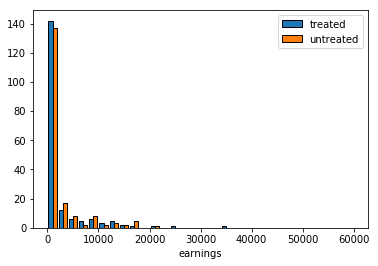

In [103]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're74', bins_, 'earnings', ['treated', 'untreated'])

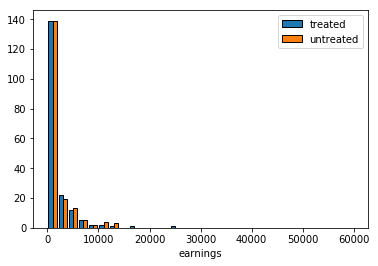

In [104]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're75', bins_, 'earnings', ['treated', 'untreated'])

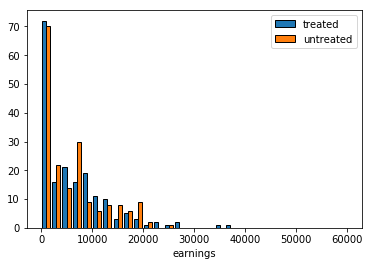

In [105]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're78', bins_, 'earnings', ['treated', 'untreated'])

We can see that the plots are very similar and give us better informations about the treated and untreated people.
Here with the analysis, we can conclude that the treatment doesn't really work because the real earnings are not higher for the treated persons than the untreated ones. So it seems logical to say that applying for this job training program has no influences. Furthermore, the differences could be caused by economic fluctuations or that maybe a the salary involves having more experiences and better skills than the training job can bring.

We can now compare the age, education and the other parameters that we have to see how the repartition of the data is done 

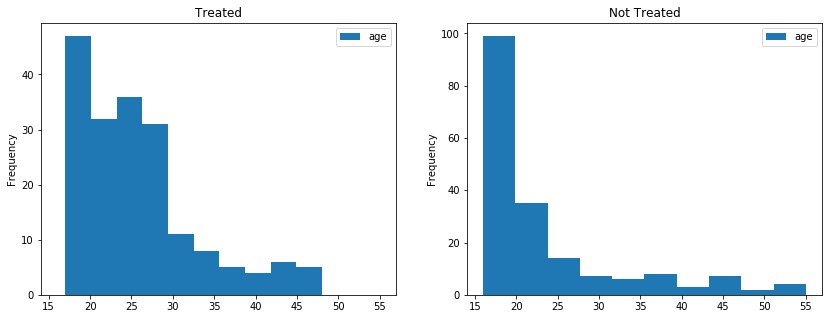

In [95]:
shared_plot_by('age', 'hist', patients_treated, patients_not_treated_matched)

In [45]:
patients_treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [46]:
patients_not_treated_matched['age'].describe()

count    185.000000
mean      23.167568
std        9.337805
min       16.000000
25%       17.000000
50%       19.000000
75%       24.000000
max       55.000000
Name: age, dtype: float64

We can see that there are much more very young people that didn't get this job training program. However both distribution has mean around 24 years old. Furthermore, we can see that for the untreated ones, the interval between the youngest and the oldest is bigger (16-55) than the treated one (17-48). So the distribution of the untreated person is more expended and can explain this mean around 24 years old.

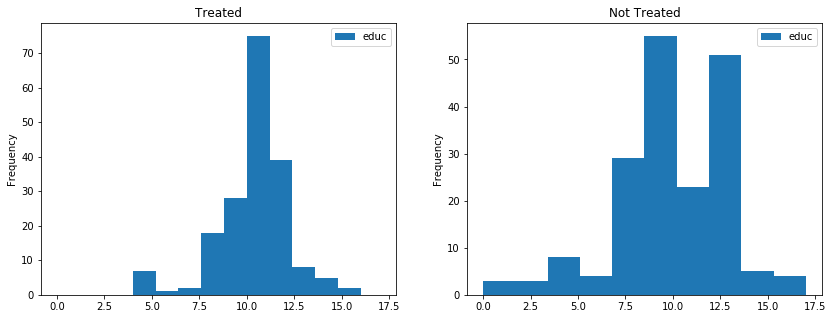

In [106]:
shared_plot_by('educ', 'hist', patients_treated, patients_not_treated_matched)

In [107]:
patients_treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [108]:
patients_not_treated_matched['educ'].describe()

count    185.000000
mean       9.864865
std        2.775692
min        0.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64

The distributions of education can be compared to a gaussian distribution with both mean around 10. Furthermore, if we look at the graph, most of the people how studied for a long time (around 10 years) took this job training program. Maybe the reason is that after about 10 years of study, another training can bring or supplement useful skills for a job.

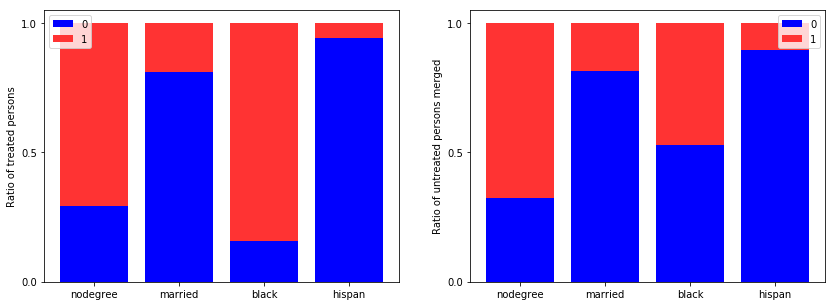

In [50]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(4)
col_names = ['nodegree', 'married', 'black', 'hispan']

result_0, result_1 = col_number(patients_treated, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(patients_not_treated_matched, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons merged')

plt.show()

We can see that the proportion of person with or without a degree is very similar in both groups. However it is still a little bit higher (red) in the treatment group, which one can conclude that if someone has no diploma, he will take the training. <br>
For the married people and hispanic ones, the proportions are the sames and it's important because with the same proportion, the final results will be coherent.<br>

### 5. Balancing the groups further